In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="4,5,6,7"

# Full wave inversion

In [ ]:
from jax import numpy as jnp
import numpy as np
from matplotlib import pyplot as plt
import jax
from livelossplot import PlotLosses

In [3]:
# Defining geometry
from jwave.geometry import kGrid, TimeAxis, Medium, Sources, Sensors, _points_on_circle, _circ_mask
from jwave.physics import simulate_wave_propagation
from jwave.signal_processing import gaussian_window, apply_ramp

N = (256,)
dx = (.5,)
source_freq = .3

grid = kGrid.make_grid(N, dx)
output_time_array = TimeAxis(dt=0.1, t_end=250.)
t = jnp.arange(0, output_time_array.t_end, output_time_array.dt)

s1 = jnp.sin(2 * jnp.pi * source_freq * t)

In [4]:
@jax.jit
def get_trace(block_sos):
    sound_speed = jnp.ones(N) 
    sound_speed = sound_speed.at[80:150].set(block_sos)
    medium = Medium(
        sound_speed=sound_speed,
        density=1.,
        attenuation=.0,
        pml_size=20
    )
    
    # define a source point
    source_mag = 5/output_time_array.dt
    center = 5
    s1 = source_mag * jnp.sin(2 * jnp.pi * source_freq * t)
    signal = gaussian_window(apply_ramp(s1, output_time_array.dt, source_freq), t, center, 8)

    source_positions = ([40],)
    sources = Sources(source_positions, signal)

    # Define sensors
    sensors_positions = ([220],)
    sensors = Sensors(positions=sensors_positions)
    
    # Get signals
    traces = simulate_wave_propagation(grid, medium, output_time_array, sources, sensors,
                                  output_t_axis = output_time_array, backprop=True)
    return traces[1][500:2000,0,0]

In [5]:
ref_trace = get_trace(1.5)

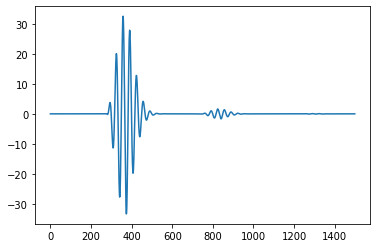

In [6]:
plt.plot(ref_trace)

In [7]:
sos_trials = jnp.linspace(1.,2.,128)

In [8]:
def mse_loss(block_sos):
    prop_trace = get_trace(block_sos)
    return jnp.mean(jnp.abs(prop_trace/jnp.std(ref_trace) - ref_trace/jnp.std(ref_trace))**2)

sos_trials = jnp.linspace(1.,2.,128)

In [9]:
errors_ls = jax.vmap(mse_loss)(sos_trials)

In [10]:
ref_trace = get_trace(1.5)

def env_loss(block_sos):
    prop_trace = get_trace(block_sos)
    x = jnp.fft.fft(prop_trace)
    x = x.at[len(x)//2:].set(0.)
    prop_trace = jnp.abs(jnp.fft.ifft(x))
    
    x = jnp.fft.fft(ref_trace)
    x = x.at[len(x)//2:].set(0.)
    x = jnp.abs(jnp.fft.ifft(x))
    
    return jnp.mean(jnp.abs(prop_trace/jnp.std(x) - x/jnp.std(x))**2)

In [11]:
errors = jax.vmap(env_loss)(sos_trials)

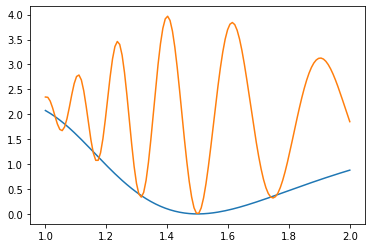

In [12]:
plt.plot(sos_trials,errors)
plt.plot(sos_trials,errors_ls)
#plt.ylim([0,150])

## Setup the problem

In [13]:
from jwextras.matlab import Matlab

In [14]:
mlb = Matlab()
mlb.start()

Opening new matlab session


In [15]:
mlb.run("clearvars")
mlb.add('/home/astanziola/repos/jwaverepo/docs/examples/_data/CT.nii', "ct_location")
#mlb.add('/home/antonios/repos/jwave/docs/examples/_data/CT.nii', "ct_location")
mlb.run("addpath(genpath('~/repos/k-plan-qms-sem/'))")

In [16]:
mlb.run_script("_matlab/fwi_setup.m")

In [17]:
# Assign variables from MATLAB workspace (which exists as a Python dictionary)
Nx = int(mlb.get("Nx"))
Ny = int(mlb.get("Ny"))
dx = float(mlb.get("dx"))
dy = float(mlb.get("dy"))
sound_speed = jnp.asarray(mlb.get("sound_speed"))
attenuation = jnp.asarray(mlb.get("attenuation"))*0. # ???
skull_mask = jnp.asarray(mlb.get("skull_mask"), dtype=float)
brain_mask = jnp.asarray(mlb.get("brain_mask"), dtype=float)

# Print grid size
print("Nx={}, Ny={}".format(Nx, Ny))

# Create grid
N = (Nx, Ny)
d = (dx, dy)
grid = kGrid.make_grid(N, d)

Nx=256, Ny=256


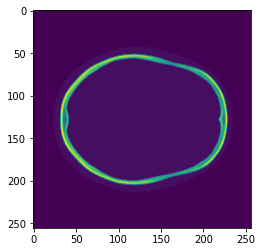

In [18]:
plt.imshow(sound_speed)

In [19]:
cfl = 0.25

# Physical properties
medium = Medium(
    sound_speed=sound_speed,
    density=jnp.ones(N),
    attenuation=0.0,
    pml_size=15
)

time_array = TimeAxis.from_kgrid(grid, medium, cfl=cfl, t_end=1e-3)
output_time_array = time_array

In [20]:
t = jnp.arange(0, time_array.t_end, time_array.dt)
t.shape

(10352,)

In [21]:
# define a source point
from jwave.signal_processing import gaussian_window, apply_ramp

num_sources = 64
source_freq = 500e3
source_mag = 5/time_array.dt


t = jnp.arange(0, time_array.t_end, time_array.dt)
center = 8e-6
s1 = source_mag * jnp.sin(2 * jnp.pi * source_freq * t)
signal = gaussian_window(apply_ramp(s1, output_time_array.dt, source_freq), t, center, 3e-6)

mask = _circ_mask(N, 128-21, (128,129))
x, y = _points_on_circle(num_sources, 128-21, (128,129))
source_positions = (jnp.array(x), jnp.array(y))

In [22]:
# Define sensors
x, y = _points_on_circle(num_sources, 128-21, (128,129), angle=np.pi/num_sources)
sensors_positions = (x, y)
sensors = Sensors(positions=sensors_positions)

Let's look at the problem setup

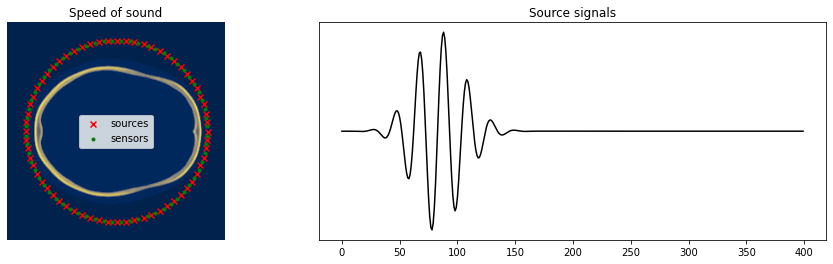

In [23]:
# Show simulation setup
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(15,4), gridspec_kw={'width_ratios': [1, 2]})

ax[0].imshow(medium.sound_speed, cmap="cividis")
ax[0].scatter(source_positions[1],source_positions[0], c='r', marker='x', label="sources")
ax[0].scatter(sensors_positions[1],sensors_positions[0], c='g', marker='.', label="sensors")
ax[0].legend()
ax[0].set_title("Speed of sound")
ax[0].axis("off")

ax[1].plot(signal[:400], label="Source 1", c='k')
ax[1].set_title("Source signals")
ax[1].get_yaxis().set_visible(False)

In [24]:
jnp.amax(medium.sound_speed)

DeviceArray(2587.9282, dtype=float32)

#### Run the simulation

In [25]:
from functools import partial
import jax

src_signal = jnp.stack([signal])

@jax.jit
def single_source_simulation(speed_of_sound,source_num):
    # Setting source
    x = jax.lax.dynamic_slice(source_positions[0], (source_num,), (1,))
    y = jax.lax.dynamic_slice(source_positions[1], (source_num,), (1,))
    sources = Sources((x,y), src_signal)
    medium = Medium(
        sound_speed=speed_of_sound,
        density=1.0,
        attenuation=0.0,
        pml_size=15
    )
    
    # Run simulations
    fields = simulate_wave_propagation(grid, medium, time_array, sources, sensors, backprop=True)
    
    # Return pressure
    p = jnp.sum(fields[1],1)*(medium.sound_speed[sources.positions]**2)
    return p

batch_simulations = jax.jit(jax.vmap(single_source_simulation, (None,0), 0))

In [26]:
p_data = batch_simulations(medium.sound_speed, jnp.arange(num_sources))
p_data = p_data + 50*jax.random.normal(jax.random.PRNGKey(42), p_data.shape)
print(p_data.shape)

(64, 10353, 64)


(10352,) 5176


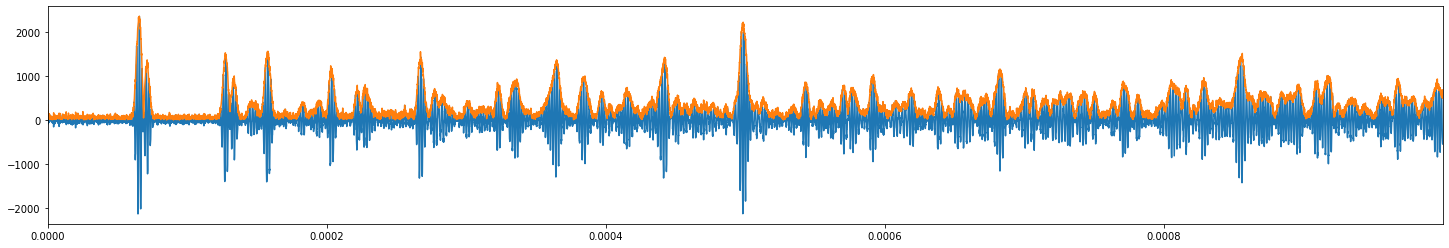

In [27]:
plt.figure(figsize=(25,4))
plt.plot(t, p_data[0,:-1,8])
plt.xlim(t[0], t[-1])

pp = p_data[0,:-1,8]
print(pp.shape, len(pp)//2)
x = jnp.fft.fft(pp, axis=0)
x = 2*x.at[len(pp)//2:].set(0.)
x = jnp.abs(jnp.fft.ifft(x, axis=0))
plt.plot(t, x)  

In [34]:
# Run simulation
p = single_source_simulation(medium.sound_speed, 1)

In [35]:
%%timeit
single_source_simulation(medium.sound_speed, 1)

875 ms ± 3.65 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [79]:
%%timeit
batch_simulations(medium.sound_speed, jnp.arange(4))

1.57 s ± 5.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Define the optimization problem

In [28]:
from jax import random, nn, value_and_grad, jit, jvp, grad, vmap, jacfwd
from jax import lax
from jax.experimental import stax
from jwave.signal_processing import smooth, apply_ramp

key = random.PRNGKey(42)

In [64]:
def get_sound_speed(params):
    return 1509*jnp.ones(N) + 1100*nn.sigmoid(params)*mask

In [65]:
def init_sos():
    old_sos_params = 0.*medium.sound_speed - 2.
    return old_sos_params
params = init_sos()
sos = get_sound_speed(params)

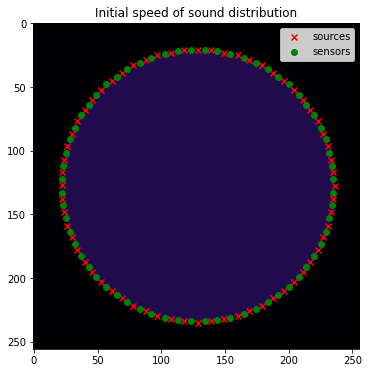

In [66]:
def plot_sos(sos, ax = None):
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(8,6))

        ax.imshow(sos, cmap="inferno", vmax=2500)
        ax.scatter(source_positions[1],source_positions[0], c='r', marker='x', label="sources")
        ax.scatter(sensors_positions[1],sensors_positions[0], c='g', marker='o', label="sensors")
        ax.legend()

plot_sos(sos)
plt.title("Initial speed of sound distribution")
plt.show()

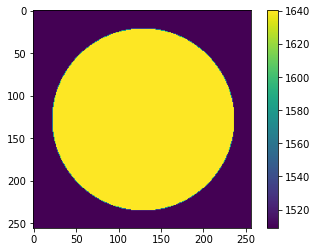

In [67]:
plt.imshow(sos)
plt.colorbar()

In [139]:
def loss_func(p, source_num):
    '''
    Maximizes energy at central sensor, minimize energy external ones'''
    diff = p_data[source_num] - p
    return 1e3*jnp.mean(jnp.abs(diff)**2)

def norm(x):
    return jnp.sum(x**2,axis=0,keepdims=True)

def cross_correlation(p, source_num):
    x = jnp.concatenate([p, jnp.zeros_like(p)])
    y = jnp.concatenate([p_data[source_num], jnp.zeros_like(p)])
    fx = jnp.fft.rfft(x, axis=0)
    fy = jnp.fft.rfft(y, axis=0)
    scale = (norm(fx)*norm(fy))
    xcorr = x.shape[0]*jnp.fft.irfft(fx*jnp.conj(fy), axis=0)/scale
    acorr = x.shape[0]*jnp.fft.irfft(fy*jnp.conj(fy), axis=0)/scale
    return jnp.fft.fftshift(xcorr), jnp.fft.fftshift(acorr)

def get_stats(xcorr):
    x = jnp.linspace(-3,3,xcorr.shape[0])
    dx = x[1]-x[0]
    std = jnp.sum((x**2)*xcorr)*dx
    mean = jnp.sum(x*xcorr)*dx
    return mean, std

                
def get_sensor_signals(speed_of_sound, source_num):
    p = single_source_simulation(speed_of_sound, source_num)
    return p

def tv(sos):
    horiz = sos[1:,:]-sos[:-1,:]
    vertical = sos[:,1:]-sos[:,:-1]
    return jnp.mean(jnp.sqrt(1e-7 + horiz[:,1:]**2 + vertical[1:,:]**2))

def loss_with_grad(params, source_num):
    
    def loss(params):
        sos = get_sound_speed(params)
        traces = get_sensor_signals(sos, source_num)
        correlation, autocorrelation = cross_correlation(traces, source_num)
        abs_xcorr = jnp.mean(jnp.abs(correlation),axis=-1)
        abs_acorr = jnp.mean(jnp.abs(autocorrelation),axis=-1)
        mean, std = get_stats(abs_xcorr)
        true_mean, true_std = get_stats(abs_acorr)
        kl = jnp.log(jnp.sqrt(std)/jnp.sqrt(true_std)) + (true_std + (true_mean - mean)**2)/(2*std)
        return kl
    
    lossval, gradient = value_and_grad(loss)(params)
    return lossval, gradient

In [140]:
sos = get_sound_speed(params)
traces = get_sensor_signals(sos, 0)
xcorr, acorr = cross_correlation(traces, 0)

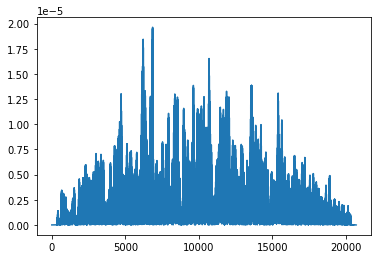

In [141]:
plt.plot(jnp.abs(xcorr)[:,0])

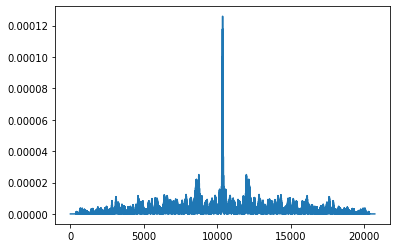

In [142]:
plt.plot(jnp.abs(acorr)[:,0])

## Optimize

In [143]:
from tqdm import tqdm
from jax.experimental import optimizers

In [150]:
lossval, gradient = loss_with_grad(params, 16)
print(lossval)

0.5033555


In [151]:
gradient

DeviceArray([[ 0.,  0., -0., ..., -0., -0., -0.],
             [-0., -0., -0., ..., -0.,  0., -0.],
             [ 0., -0.,  0., ..., -0., -0.,  0.],
             ...,
             [ 0.,  0., -0., ..., -0.,  0.,  0.],
             [-0.,  0.,  0., ..., -0., -0.,  0.],
             [ 0.,  0.,  0., ..., -0., -0.,  0.]], dtype=float32)

Text(0.5, 1.0, 'Gradient')

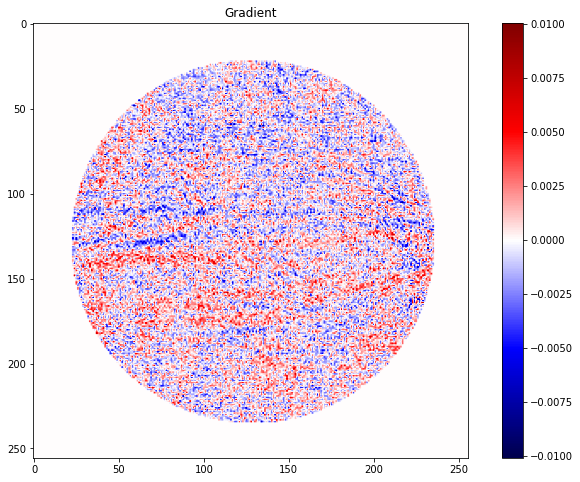

In [152]:
plt.figure(figsize=(12,8))
plt.imshow(gradient, cmap="seismic")
plt.colorbar()
plt.title("Gradient")

In [130]:
def relu(x):
    return jnp.where(x<0.,0.,x)

  0%|          | 0/1000 [00:00<?, ?it/s]

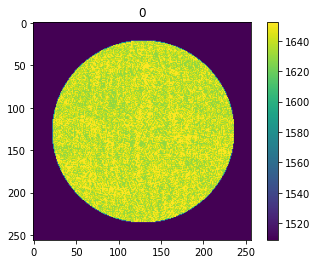

Loss: 0.5034:   1%|          | 10/1000 [01:08<1:31:28,  5.54s/it]

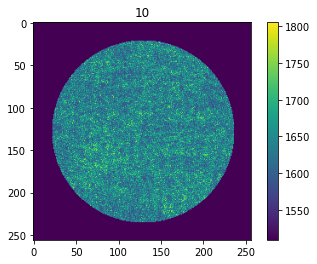

Loss: 0.5045:   2%|▏         | 20/1000 [02:04<1:38:56,  6.06s/it]

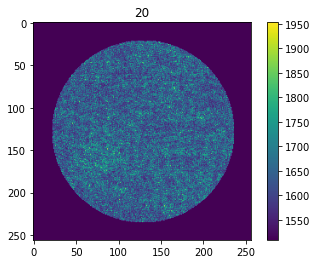

Loss: nan:   3%|▎         | 30/1000 [03:01<1:27:58,  5.44s/it]   

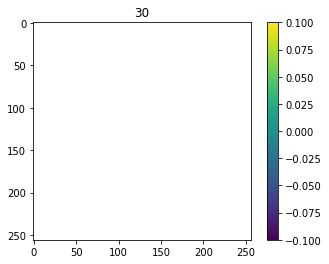

Loss: nan:   4%|▍         | 40/1000 [04:01<1:36:13,  6.01s/it]

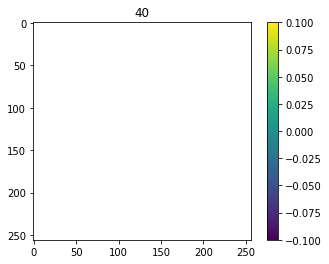

Loss: nan:   5%|▌         | 50/1000 [04:54<1:32:48,  5.86s/it]

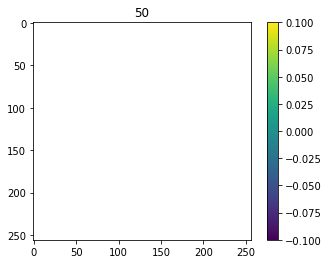

Loss: nan:   5%|▌         | 54/1000 [05:24<1:34:43,  6.01s/it]


KeyboardInterrupt: 

In [155]:
losshistory = []
reconstructions = []

init_fun, update_fun, get_params = optimizers.adam(.1, 0.9, 0.9)
opt_state = init_fun(params)

@jax.jit
def update(opt_state, key, k):
    v = get_params(opt_state)
    
    # Splitting sources in a 4 by 8 matrix.
    # Each GPU will process 2 sources in parallel
    src_num = random.choice(key, num_sources, shape=(jax.device_count(),), replace=False)
    
    # Running entire gradient computation in parallel, with each
    # gpu doing 4 simulations in parallel
    lossvals, gradients = jax.pmap(
        loss_with_grad, 
        in_axes=(None,0)
    )(v, src_num)
    
    # Only moves data to host to take averages
    gradient = jnp.mean(gradients, axis=(0,))
    lossval = jnp.mean(lossvals, axis=(0,))
    
    # Weighting full gradients and smoothed gradients
    return lossval, update_fun(k, gradient*mask, opt_state)

#pbar = tqdm(range(1000))
_, key = random.split(random.PRNGKey(32))
pbar = tqdm(range(1000))
for k in pbar:
    _, key = random.split(key)
    lossval, opt_state = update(opt_state, key, float(k))
    
    # For logging
    new_params = get_params(opt_state)
    reconstructions.append(np.array(get_sound_speed(new_params)))
    losshistory.append(lossval)
    
    if k % 10 == 0:
        plt.imshow(reconstructions[-1])
        plt.title("{}".format(k))
        plt.colorbar()
        plt.show()
    
    pbar.set_description("Loss: {:01.4f}".format(lossval))

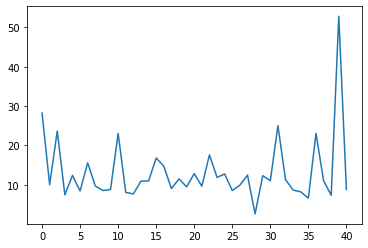

In [132]:
plt.plot(losshistory)

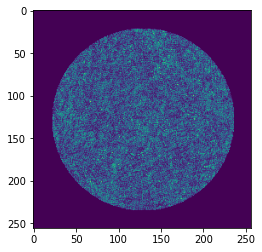

In [134]:
plt.imshow(reconstructions[-1])

In [109]:
new_params = get_params(opt_state)

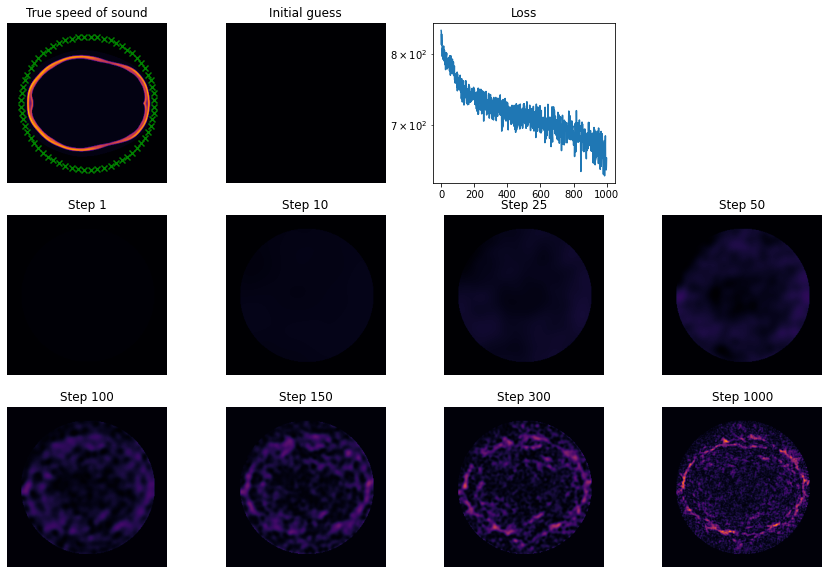

In [113]:
sos_original = get_sound_speed(params)
true_sos = sound_speed

fig, axes = plt.subplots(3,4, figsize=(15,10))

k = 0
recs = list(map(lambda x: x-1, [1, 10, 25, 50, 100, 150, 300, 1000]))
#recs = list(map(lambda x: x-1, [10,20,30,40, 50, 60,75, 95]))
for row in range(3):
    for col in range(4):
        if k ==0:
            axes[row,col].imshow(true_sos, vmax=2700, cmap="inferno")
            axes[row,col].scatter(sensors_positions[1],sensors_positions[0], c='g', marker='x', label="sensors")
            axes[row,col].set_title("True speed of sound")
            axes[row,col].set_axis_off()
        elif k ==1:
            axes[row,col].imshow(sos_original, vmax=2700, cmap="inferno")
            axes[row,col].set_axis_off()
            axes[row,col].set_title("Initial guess")
        elif k ==2:
            axes[row,col].plot(losshistory)
            axes[row,col].set_title("Loss")
            axes[row,col].set_yscale("log")
        elif k == 3:
            axes[row,col].set_axis_off()
        else:
            axes[row,col].imshow(reconstructions[recs[k-4]], vmax=2700, cmap="inferno")
            axes[row,col].set_axis_off()
            axes[row,col].set_title("Step {}".format(recs[k-4]+1))
        k += 1

In [ ]:
sos_original = get_sound_speed(params)
true_sos = sound_speed

fig, axes = plt.subplots(3,4, figsize=(15,10))

k = 0
recs = list(map(lambda x: x-1, [1, 10, 25, 50, 100, 200, 350, 500]))
for row in range(3):
    for col in range(4):
        if k ==0:
            axes[row,col].imshow(true_sos, vmax=1.7, cmap="inferno")
            axes[row,col].scatter(sensors_positions[1],sensors_positions[0], c='g', marker='x', label="sensors")
            axes[row,col].set_title("True speed of sound")
            axes[row,col].set_axis_off()
        elif k ==1:
            axes[row,col].imshow(sos_original, vmax=1.7, cmap="inferno")
            axes[row,col].set_axis_off()
            axes[row,col].set_title("Initial guess")
        elif k ==2:
            axes[row,col].plot(losshistory)
            axes[row,col].set_title("Loss")
            axes[row,col].set_yscale("log")
        elif k == 3:
            axes[row,col].set_axis_off()
        else:
            axes[row,col].imshow(reconstructions[recs[k-4]], vmax=1.7, cmap="inferno")
            axes[row,col].set_axis_off()
            axes[row,col].set_title("Step {}".format(recs[k-4]+1))
        k += 1